# Análisis espectral de un fragmento de señal

En este cuaderno comenzaremos a ver cómo obtener el espectro de una señal, es decir **cómo descomponerla como suma de sinusoides**

Para ello analizaremos sonidos producidos por un instrumento musical.

La herramienta básica de análisis que emplearemos será la DFT/FFT. Como sabemos de teoría:

 * la DFT trata de estimar las amplitudes y fases en un conjunto discreto de frecuencias.
 
 * El conjunto de frecuencias se puede hacer tan denso como se desee sin más que añadir ceros a las muestras de la señal antes de empezar.
 
 * La DFT realiza una suma en vez de una media, por lo que para estimar las amplitudes hay que dividor por *L*, el número de muestras de señal empleado.
 
 * Las amplitudes de las sinusoides (espectro unilateral) se obtienen multiplicando por 2 las amplitudes de los fasores (espectro bilateral)
 
 * El cálculo de la DFT se puede hacer de manera especialmente eficiente si el número de muestras (incluido el relleno por ceros) es **potencia entera de 2**. El caso más desfavorable es cuando el número de muestras es primo y grande.

In [1]:
import numpy as np
from scipy import signal
from scipy.io import wavfile
import matplotlib
import matplotlib.pyplot as plt
import math
import warnings; warnings.simplefilter('ignore') # Para quitar mensajes de warning
import upv_audio 
matplotlib.rcParams['figure.figsize'] = (10, 5)
from IPython.display import Audio

import UPVlog
notebook_filename="2-6 Analisis Espectral Guitarra"
mylogger=UPVlog.UPVlog(notebook_filename)

Comenzaremos leyendo una señal de audio que contiene una pulsación de una cuerda de una guitarra. Si el alumno lo desea, puede emplear grabaciones propias de cualquier instrumento de cuerda o viento

In [2]:
#Esto lo dejaremos para cuando lo necesitemos
f_cuerdas  = [329.63, 246.94, 196.00, 146.8, 110, 82.41]
#leemos el audio
fs,x2=upv_audio.read('audios/guitarra/c2.wav')
print(fs)
print(x2.shape)

44100
(150586,)


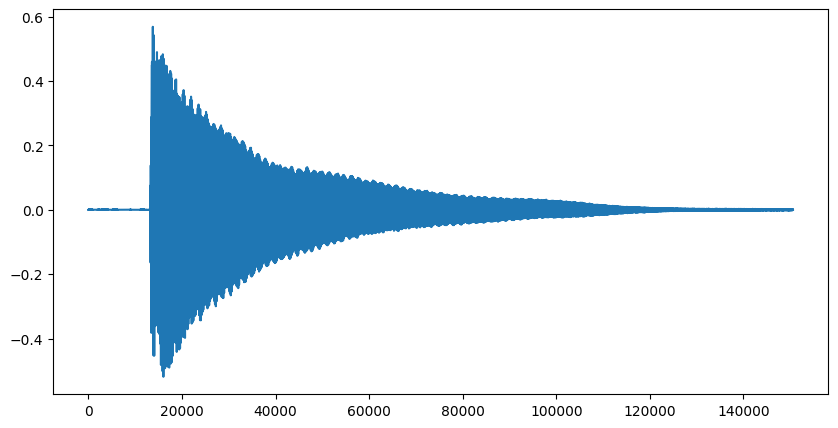

In [3]:
#Representamos a ver qué tenemos
%matplotlib inline
_=plt.plot(x2)

Analizaremos un fragmento de la señal en el que esta sea estable. Por ejemplo a partir de la muestra **30000**

## Determinación del periodo mediante observación en el dominio del tiempo

Representaremos un pequeño fragmento para comprobar que es *aproximádamente* periódica

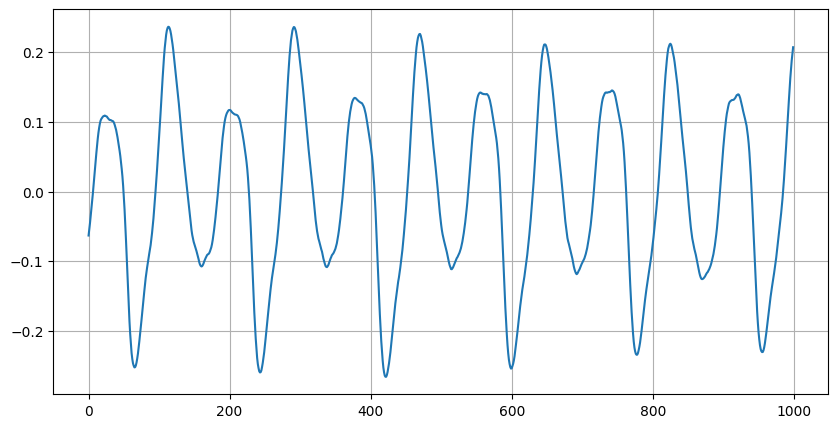

In [4]:
_=plt.plot(x2[30000:31000])
_=plt.grid()

A *ojo* podemos ver que el periodo son una 180 muestras, que corresponde con una frecuencia de 

In [5]:
# Complete el valor de frec_fundamental
frec_fundamental= None

### BEGIN SOLUTION
frec_fundamental = fs/180
### END SOLUTION


In [6]:
mylogger.log("Testing frec_fundamental cuerda 2")
### BEGIN TESTS
assert frec_fundamental is not None
assert frec_fundamental > 240 and frec_fundamental < 250
### END TESTS

### BEGIN HIDDEN TESTS
assert abs(frec_fundamental-fs/180) < 1
### END HIDDEN TESTS
mylogger.log("Success Testing frec_fundamental cuerda 2")

Podemos ver que es similar a la segunda cuerda, pese a haber elegido el periodo totalmente *a ojo*

In [7]:
f_cuerdas[2-1] # La primera cuerda es el elemento 0

246.94

A continuación repetir el mismo procedimiento para estimar la frecuencia fundamental de la primera cuerda

44100
(141947,)


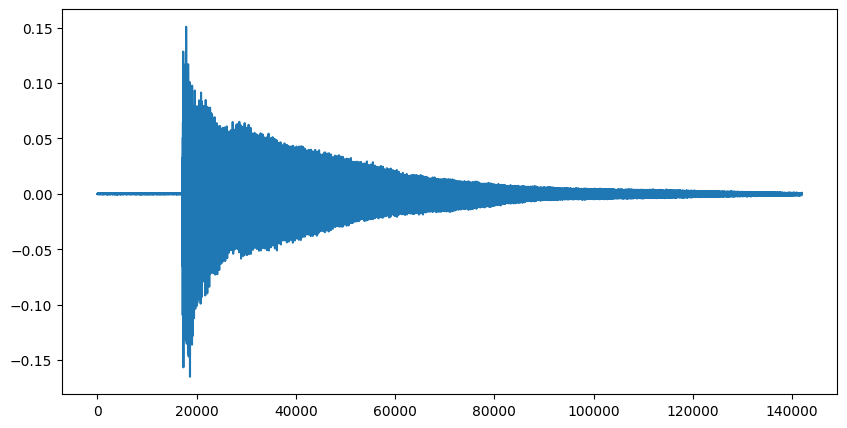

In [8]:
# Lectura audio cuerda 1
fs,x1=upv_audio.read('audios/guitarra/c1.wav')
print(fs)
print(x1.shape)
_=plt.plot(x1)

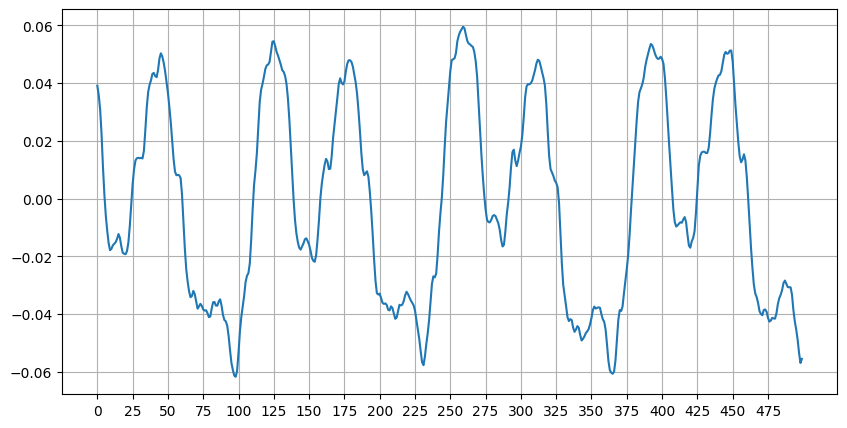

In [9]:
# Representar grácicamente un fragmento de 500 muestras
ini=None # Seleccionar el comienzo del fragmento
### BEGIN SOLUTION
ini=25000
### END SOLUTION
fin=ini+500
_=plt.plot(x1[ini:fin])
_=plt.xticks(np.arange(0,500,25))
_=plt.grid()


In [10]:
# A partir de la gráfica estimar el periodo en muestras y la frecuencia fundamental en Hz (teniendo en cuenta fs)

periodo_muestras1=None
frec_fundamental1 = None

### BEGIN SOLUTION
periodo_muestras1 = 133
frec_fundamental1 = fs / periodo_muestras1
### END SOLUTION

In [11]:
mylogger.log("Testing frec_fundamental 1")
### BEGIN TESTS
assert ini is not None
assert periodo_muestras1 is not None and frec_fundamental1 is not None
assert periodo_muestras1 > 110 and periodo_muestras1 < 150
### END TESTS

### BEGIN HIDDEN TESTS
assert periodo_muestras1> 125 and periodo_muestras1< 137
### END HIDDEN TESTS
print(frec_fundamental1)
mylogger.log("Sucess Testing frec_fundamental 1")

331.57894736842104


In [12]:
# La frecuencia de la primera cuerda bien afinada es

print(f_cuerdas[1-1])

329.63


## Estimación de la frecuencia fundamental usando FFT

Para empezar el **análisis de verdad**, tomaremos un fragmento de **medio segundo** empezando en la muestra 40000 de la cuerda 2

In [13]:
ini=40000
fin = None
### BEGIN SOLUTION
fin = ini + int(fs*0.5)
### END SOLUTION
trozo=x2[ini:fin]

In [14]:
mylogger.log("Testing fin FFT2")
### BEGIN TESTS
assert fin is not None
assert fin > 50000 and  fin < 70000
### END TESTS

# Tests Ocultos para comprobar el valor 
### BEGIN HIDDEN TESTS
assert fin - ini == int(fs*0.5)
### END HIDDEN TESTS
mylogger.log("Sucess Testing fin FFT2")

In [15]:
def espectroFFT(x, NFFT=None):
    
    # Si no damos NFFT es directamente la longitud de la señal
    L=len(x)
    if NFFT==None:
        NFFT = L 
       
    # Comprobamos que NFFT sea mayor que la longitud de x.
    assert L<=NFFT, 'NFFT tiene que ser mayor o igual a que len(x)'

    # Calculamos la FFT. Se rellena con ceros desde L a NFFT 
    X = np.fft.fft(x,NFFT)
   
    A=1/L*np.abs(X)
   
    # Generamos el eje de frecuencia digital
    fd = np.arange(0, NFFT)/NFFT
    
  # Nos quedamos con la primera mitad (hasta frec 0.5)
    A=A[0:NFFT//2]
    fd=fd[0:NFFT//2]
    
    return A,fd 

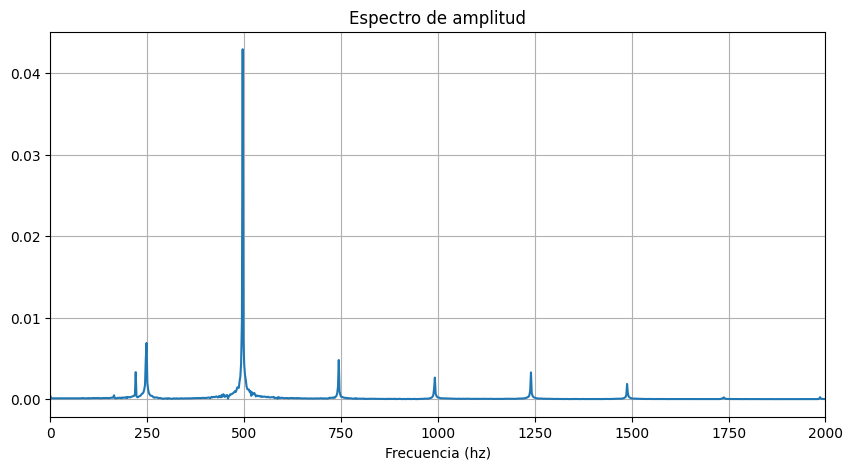

In [16]:
X,f=espectroFFT(trozo)
_=plt.plot(f*fs,X)
_=plt.xlabel('Frecuencia (hz)')
_=plt.title('Espectro de amplitud')
_=plt.grid()
_=plt.xlim(0,2000)

Se puede observar:
* Estructura de armónicos de la señal
* Que el armónico de más amplitud **NO** es el fundamental.
* Que las amplitudes son prácticamente 0 por encima de 2 kHz

____________________


### Determinación de la frecuencia fundamental Cuerda 2

Para obtener la frecuencia fundamental hay que determinar la separación entre los picos del escpectro. Una manera es:
* coger el armónico k-ésimo

* Determinar su frecuencia mediante la posición del pico

* Dividir la frecuencia por *k*

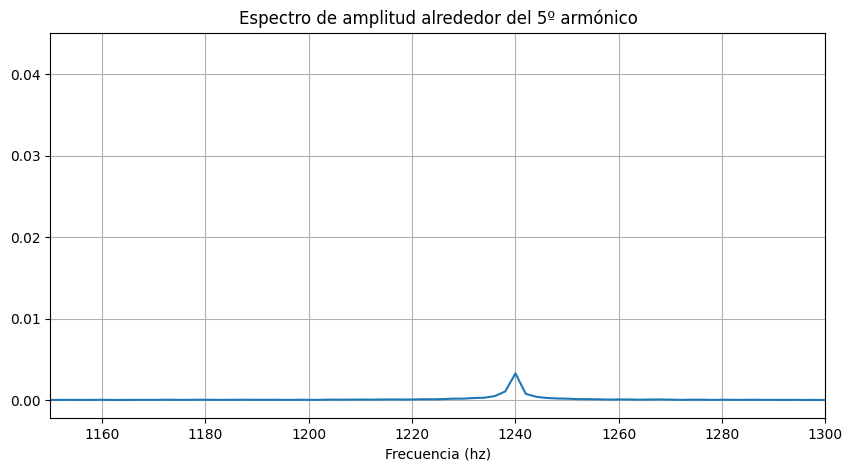

In [17]:
X,f=espectroFFT(trozo)
_=plt.plot(f*fs,X)
_=plt.xlabel('Frecuencia (hz)')
_=plt.title('Espectro de amplitud alrededor del 5º armónico')
_=plt.grid()
_=plt.xlim(1150,1300)

In [18]:
frec_fundamental2_fft = None
### BEGIN SOLUTION
frec_fundamental2_fft = 1240 /5
### END SOLUTION

In [19]:
mylogger.log("Testing frec_fundamental2_fft")
### BEGIN TESTS
frec_fundamental2_fft is not None
assert frec_fundamental2_fft> 200 and frec_fundamental2_fft < 300
### END TESTS

### BEGIN HIDDEN TESTS
frec_fundamental2_fft is not None
assert abs(frec_fundamental2_fft - 1240/5) < 5
### END HIDDEN TESTS
print('Frecuencia estimada:',frec_fundamental2_fft)
print('Frecuencia teórica cuerda 2:',f_cuerdas[2-1])
mylogger.log("Success Testing frec_fundamental2_fft")

Frecuencia estimada: 248.0
Frecuencia teórica cuerda 2: 246.94


### Determinación frecuencia fundamental cuerda 5

Para estar seguro de que ha comprendido el procedimiento complete las celdas siguientes para la estima de la manera más exacta posible de la frecuencia fundamental de la **cuerda 5**

In [20]:
# Cargue fichero audio
mylogger.log("Cargando cuerda 5")
x5 = None # Muestras de la señal de la cuerda 5

### BEGIN SOLUTION
fs,x5=upv_audio.read('audios/guitarra/c5.wav')
### END SOLUTION


In [21]:

# Comprobación de la carga
mylogger.log("Testing load c5")
### BEGIN TESTS
assert x5 is not None, "x5 debe contener las muestras de la cuerda 5"
### END TESTS

### BEGIN HIDDEN TESTS
assert len(x5) == 220943
### END HIDDEN TESTS
mylogger.log("Success Testing load c5")

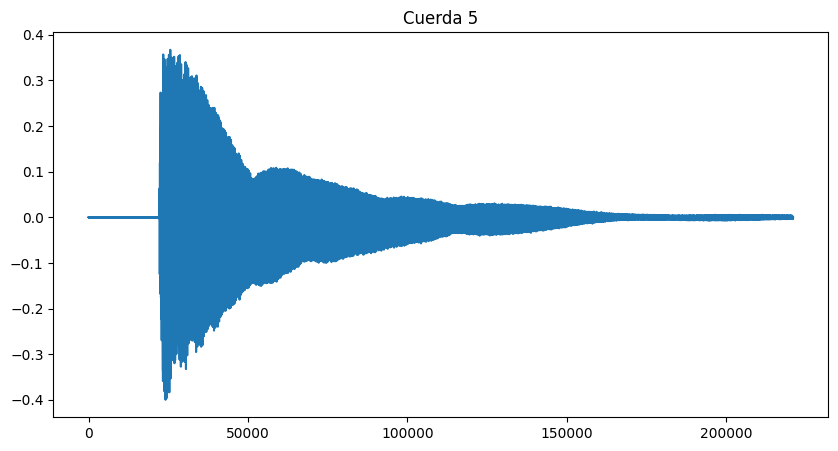

In [22]:
# Representación de la señal completa
_=plt.plot(x5)
_=plt.title('Cuerda 5')

In [23]:
# Selección de un trozo de medio segundo de cuerda 5
ini5 = None
fin5 = None
### BEGIN SOLUTION
ini5 = 50000
fin5 = ini5 + int(fs*0.5)
### END SOLUTION

trozo5=x5[ini5:fin5]

In [24]:
mylogger.log("Testing ini fin c5")
### BEGIN TESTS
assert ini5 is not None and fin5 is not None, "x5 debe contener las muestras de la cuerda 5"
### END TESTS

### BEGIN HIDDEN TESTS
assert fin5-ini5 ==int(0.5*fs)
### END HIDDEN TESTS
mylogger.log("Success Testing ini fin c5")

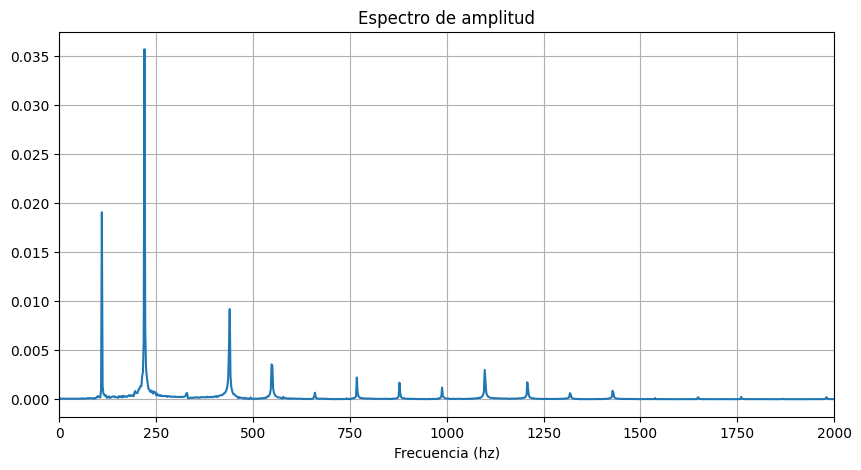

In [25]:
X5,f=espectroFFT(trozo5)
_=plt.plot(f*fs,X5)
_=plt.xlabel('Frecuencia (hz)')
_=plt.title('Espectro de amplitud')
_=plt.grid()
_=plt.xlim(0,2000)

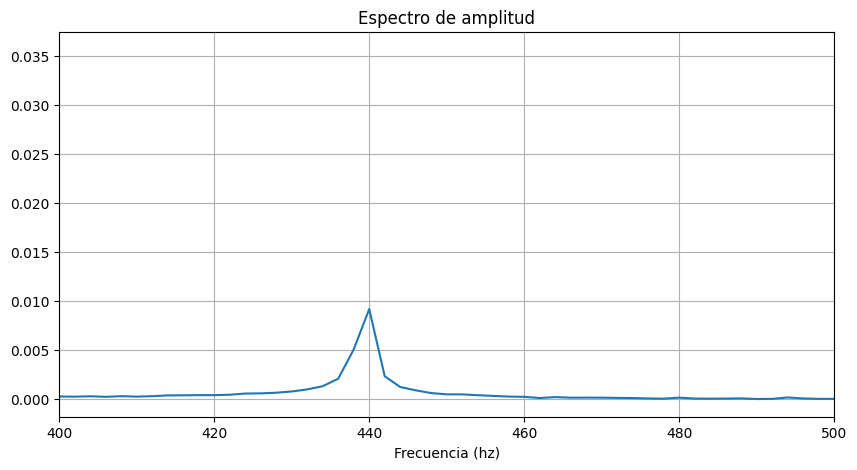

In [26]:
# Represente aquí un detalle ALREDEDOR DEL  4º ARMÓNICO y estime frecuencia fundamental

frec_fundamental5_fft = None
### BEGIN SOLUTION
_=plt.plot(f*fs,X5)
_=plt.xlabel('Frecuencia (hz)')
_=plt.title('Espectro de amplitud')
_=plt.grid()
_=plt.xlim(400,500)
frec_fundamental5_fft = 440 /4
### END SOLUTION


In [27]:
mylogger.log("Testing frec_fundamental c5 fft")
### BEGIN TESTS
assert frec_fundamental5_fft is not None 
### END TESTS

### BEGIN HIDDEN TESTS
assert abs(frec_fundamental5_fft-110) < 5
### END HIDDEN TESTS

print('Frecuencia estimada:',frec_fundamental5_fft)
print('Frecuencia teórica cuerda 5:',f_cuerdas[5-1])
mylogger.log("Sucess Testing frec_fundamental c5 fft")


Frecuencia estimada: 110.0
Frecuencia teórica cuerda 5: 110
